## Inertial oscillation and wind direction

### Introduction
This notebook aims to visualize inertial oscillations as well as wind fluctuations.

### Data Sources
- Drifter Data:
  - Source: NOAA
  - Collection Frequency: Every 6 hours
  - Total Number of Drifters: 221

## Import Library


In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from cartopy import config
import matplotlib.animation

## Read Drifter Data


In [2]:
fn='./drifter_6hour_qc_893c_d15d_c4b7_U1711967648742.nc';
ds=xr.open_dataset(fn);

## Extract Coordinates and Variables


In [3]:
ve_curr = ds.ve.values
vn_curr = ds.vn.values
sst = ds.sst.values
lon = ds.longitude.values
lat = ds.latitude.values
time = ds.time.values

## Creation of Pandas Array for Drifter Data


In [4]:
data = {
    'longitude': lon,
    'latitude' : lat,
    'time'     : time,
    've'       : ve_curr,
    'vn'       : vn_curr,
    'sst'      : sst
}

df = pd.DataFrame(data)
df

,longitude,latitude,time,ve,vn,sst
0,-14.478,-18.548,2023-01-01 00:00:00,-0.13760,-0.07635,23.612
1,-14.499,-18.556,2023-01-01 06:00:00,-0.09969,0.01322,23.564
2,-14.519,-18.543,2023-01-01 12:00:00,-0.15719,0.08193,23.699
3,-14.563,-18.524,2023-01-01 18:00:00,-0.26155,0.03533,23.856
4,-14.626,-18.529,2023-01-02 00:00:00,-0.23922,-0.07837,23.717
...,...,...,...,...,...,...
78378,-22.006,-19.946,2023-06-11 12:00:00,-0.03853,-0.05076,25.189
78379,-22.013,-19.961,2023-06-11 18:00:00,-0.05150,-0.06262,25.179
78380,-22.027,-19.971,2023-06-12 00:00:00,-0.06030,-0.04773,25.133
78381,-22.038,-19.980,2023-06-12 06:00:00,-0.06036,-0.05688,25.093


## Selecting Drifter Data


In [5]:
# Test: Our selected drifter has 1102 observations. However, we will limit it to 158 observations because the coordinates 
# of our CMEMS data are 158 in dimension, and the linear interpolation method we use requires it in this situation.

df_1 = df[16129:16290]
df_1

,longitude,latitude,time,ve,vn,sst
16129,-1.824,2.193,2023-01-01 00:00:00,-0.20141,0.03785,29.958
16130,-1.859,2.201,2023-01-01 06:00:00,-0.19177,-0.00909,29.682
16131,-1.898,2.190,2023-01-01 12:00:00,-0.22554,-0.05266,29.991
16132,-1.946,2.180,2023-01-01 18:00:00,-0.18678,-0.05015,29.888
16133,-1.971,2.170,2023-01-02 00:00:00,-0.16427,0.00519,29.645
...,...,...,...,...,...,...
16285,-2.393,1.452,2023-02-09 00:00:00,-0.05208,-0.00764,29.370
16286,-2.407,1.443,2023-02-09 06:00:00,-0.09199,-0.01783,29.316
16287,-2.429,1.445,2023-02-09 12:00:00,-0.10036,-0.00318,29.521
16288,-2.446,1.442,2023-02-09 18:00:00,-0.09536,0.02611,29.550


## Visualisation of Inertial oscillation and wind direction


## conclusion
The wind is from the East, and inertial oscillations tend to follow the same direction as the wind

C:\Users\PC-M2OA\AppData\Local\Temp\ipykernel_16560\1675216018.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['time'] = (df_1['time'] - df_1['time'].iloc[0]).dt.total_seconds()


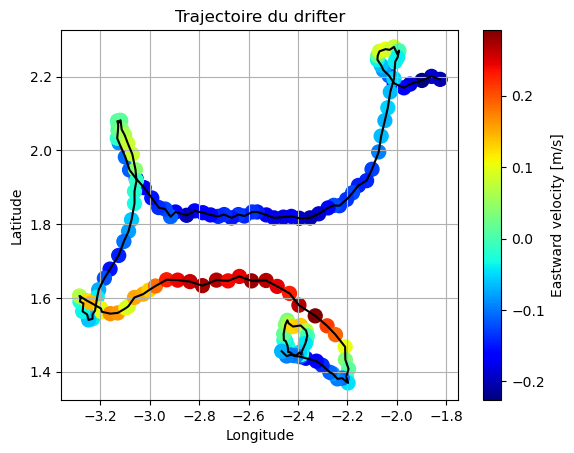

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame with longitude, latitude, temperature, and time
# Replace this with your actual DataFrame
df_1 = df[16129:16290]

# Convertir la colonne temps en un format numérique représentant le temps écoulé (en secondes)
df_1['time'] = (df_1['time'] - df_1['time'].iloc[0]).dt.total_seconds()

# Tracer la force inertielle en 2D avec des croix reliant les points de trajectoire
plt.scatter(df_1['longitude'], df_1['latitude'], c=df_1['ve'], cmap='jet', s=100, marker='o')
plt.colorbar(label='Eastward velocity [m/s]')

# Tracer la ligne reliant les points de trajectoire
plt.plot(df_1['longitude'], df_1['latitude'], color='k', linestyle='-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trajectoire du drifter')
# Add grid
plt.grid(True)
plt.savefig("fig78_mode.png")
plt.show()

In [12]:
import pandas as pd
import xarray as xr
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Charger les données du DataFrame contenant les informations sur l'onde inertielle
df_inertial_wave = df[16129:16290]  # Assurez-vous de fournir le bon chemin d'accès

# Charger les données du fichier NetCDF contenant les composantes U et V du vent
ds_wind = xr.open_dataset("cmems_obs-wind_glo_phy_my_l4_P1M_1715561830429.nc")  # Assurez-vous de fournir le bon chemin d'accès

# Sélectionner les variables U et V du vent
u_wind = ds_wind['eastward_wind']
v_wind = ds_wind['northward_wind']

# Interpoler les données du vent aux mêmes positions spatiales que les données de l'onde inertielle
u_interp = u_wind.interp(latitude=df_inertial_wave['latitude'], longitude=df_inertial_wave['longitude'], time=df_inertial_wave['time'], method='linear')

v_interp = v_wind.interp(latitude=df_inertial_wave['latitude'], longitude=df_inertial_wave['longitude'], time=df_inertial_wave['time'], method='linear')

# Calculer les valeurs moyennes de longitude et de latitude
mean_longitude = df_inertial_wave['longitude'].mean()
mean_latitude = df_inertial_wave['latitude'].mean()

# Moyenne des valeurs de u_interp et v_interp le long du temps
mean_u_interp = np.mean(u_interp, axis=0)
mean_v_interp = np.mean(v_interp, axis=0)

# Spécifier le nombre de points désirés pour la grille d'onde inertielle
desired_lon_points = 15
desired_lat_points = 15

# Calculer les facteurs de sous-échantillonnage
lon_subsample_factor = int(df_inertial_wave['longitude'].size / desired_lon_points)
lat_subsample_factor = int(df_inertial_wave['latitude'].size / desired_lat_points)

# Sous-échantillonnage des données de vent pour correspondre à la résolution de la grille d'onde inertielle
u_interp_subsampled = u_interp[:, ::lon_subsample_factor, ::lat_subsample_factor]
v_interp_subsampled = v_interp[:, ::lon_subsample_factor, ::lat_subsample_factor]

# Afficher les quivers avec les valeurs moyennes
plt.figure(figsize=(10, 8))
plt.quiver(u_interp_subsampled.longitude.values, v_interp_subsampled.latitude.values, u_interp_subsampled.mean(axis=0), v_interp_subsampled.mean(axis=0), scale=(200), width=0.02)
plt.scatter(df_inertial_wave['longitude'], df_inertial_wave['latitude'], c=df_inertial_wave['ve'], cmap='jet', s=100, marker='o')
# plt.colorbar(label='Eastward velocity [m/s]')

# Tracer la ligne reliant les points de trajectoire
plt.plot(df_inertial_wave['longitude'], df_inertial_wave['latitude'], color='k', linestyle='-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trajectoire de l\'onde inertielle et direction des vents')
plt.colorbar(label='Onde inertielle')
plt.grid(True)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: b'C:\\Users\\PC-M2OA\\Desktop\\Jule\\cmems_obs-wind_glo_phy_my_l4_P1M_1715561830429.nc'

-1236

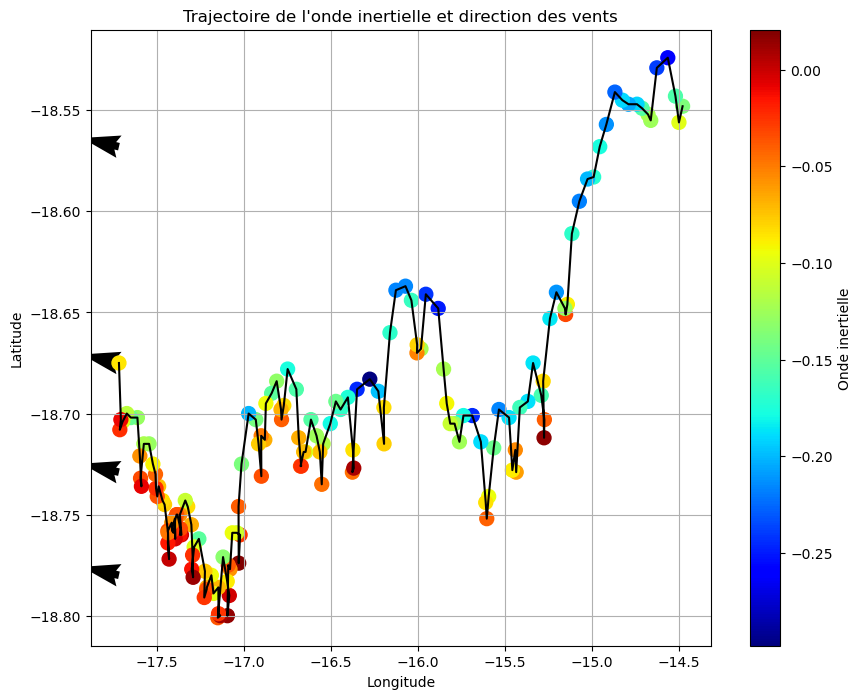

In [26]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Charger les données du DataFrame contenant les informations sur l'onde inertielle
df_inertial_wave = df[0:158]  # Assurez-vous de fournir le bon chemin d'accès

# Charger les données du fichier NetCDF contenant les composantes U et V du vent
ds_wind = xr.open_dataset("cmems_obs-wind_glo_phy_my_l4_P1M_1715561830429.nc")  # Assurez-vous de fournir le bon chemin d'accès

# Sélectionner les variables U et V du vent
u_wind = ds_wind['eastward_wind']
v_wind = ds_wind['northward_wind']

# Interpoler les données du vent aux mêmes positions spatiales que les données de l'onde inertielle
u_interp = u_wind.interp(latitude=df_inertial_wave['latitude'], longitude=df_inertial_wave['longitude'], time=df_inertial_wave['time'], method='linear')

v_interp = v_wind.interp(latitude=df_inertial_wave['latitude'], longitude=df_inertial_wave['longitude'], time=df_inertial_wave['time'], method='linear')

# Calculer les valeurs moyennes de longitude et de latitude
mean_longitude = df_inertial_wave['longitude'].mean()
mean_latitude = df_inertial_wave['latitude'].mean()

# Moyenne des valeurs de u_interp et v_interp le long du temps
mean_u_interp = np.mean(u_interp, axis=0)
mean_v_interp = np.mean(v_interp, axis=0)

# Calcul de la résolution de la grille d'onde inertielle
resolution_lon = df_inertial_wave['longitude'].diff().mean()
resolution_lat = df_inertial_wave['latitude'].diff().mean()

# Sous-échantillonnage des données de vent pour correspondre à la résolution de la grille d'onde inertielle
u_interp_subsampled = u_interp[:, ::int(1/resolution_lon), ::int(1/resolution_lat)]
v_interp_subsampled = v_interp[:, ::int(1/resolution_lon), ::int(1/resolution_lat)]


# Afficher les quivers avec les valeurs moyennes
plt.figure(figsize=(10, 8))
plt.quiver(u_interp_subsampled.longitude.values, v_interp_subsampled.latitude.values, u_interp_subsampled.mean(axis=0), v_interp_subsampled.mean(axis=0), scale=(100), width=0.02)
# Tracer la force inertielle en 2D avec des croix reliant les points de trajectoire
plt.scatter(df_inertial_wave['longitude'], df_inertial_wave['latitude'], c=df_inertial_wave['ve'], cmap='jet', s=100, marker='o')
# plt.colorbar(label='Eastward velocity [m/s]')

# Tracer la ligne reliant les points de trajectoire
plt.plot(df_inertial_wave['longitude'], df_inertial_wave['latitude'], color='k', linestyle='-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trajectoire de l\'onde inertielle et direction des vents')
plt.colorbar(label='Onde inertielle')
plt.grid(True)
plt.savefig("fig79_mode.png")
plt.show()

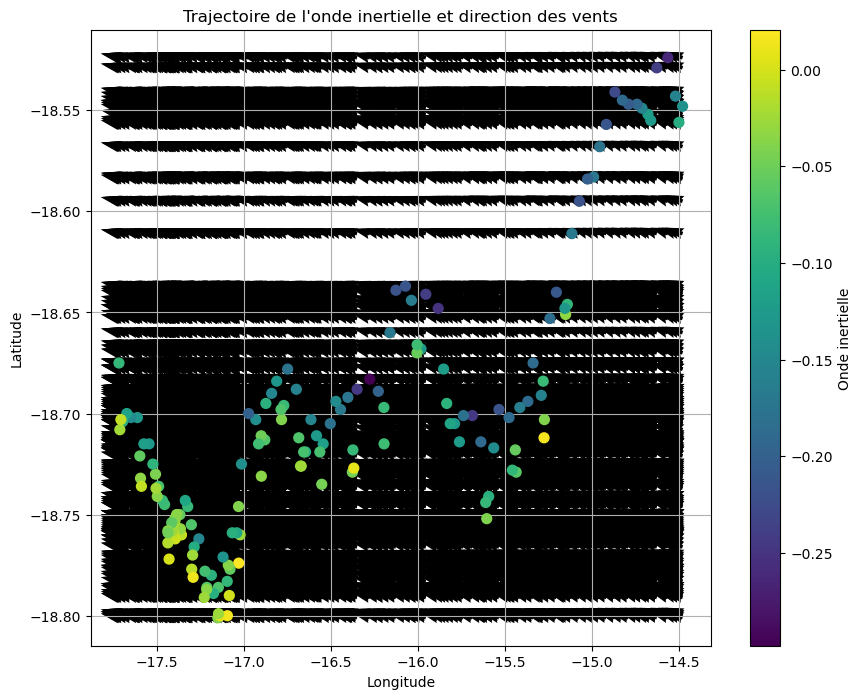

In [29]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Charger les données du DataFrame contenant les informations sur l'onde inertielle
df_inertial_wave = df[0:158]  # Assurez-vous de fournir le bon chemin d'accès

# Charger les données du fichier NetCDF contenant les composantes U et V du vent
ds_wind = xr.open_dataset("cmems_obs-wind_glo_phy_my_l4_P1M_1715561830429.nc")  # Assurez-vous de fournir le bon chemin d'accès

# Sélectionner les variables U et V du vent
u_wind = ds_wind['eastward_wind']
v_wind = ds_wind['northward_wind']

# Interpoler les données du vent aux mêmes positions spatiales que les données de l'onde inertielle
u_interp = u_wind.interp(latitude=df_inertial_wave['latitude'], longitude=df_inertial_wave['longitude'], time=df_inertial_wave['time'], method='linear')

v_interp = v_wind.interp(latitude=df_inertial_wave['latitude'], longitude=df_inertial_wave['longitude'], time=df_inertial_wave['time'], method='linear')

# Calculer les valeurs moyennes de longitude et de latitude
mean_longitude = df_inertial_wave['longitude'].mean()
mean_latitude = df_inertial_wave['latitude'].mean()

# Moyenne des valeurs de u_interp et v_interp le long du temps
mean_u_interp = np.mean(u_interp, axis=0)
mean_v_interp = np.mean(v_interp, axis=0)

# Calcul de la résolution de la grille d'onde inertielle
resolution_lon = df_inertial_wave['longitude'].diff().mean()
resolution_lat = df_inertial_wave['latitude'].diff().mean()

# Sous-échantillonnage des données de vent pour correspondre à la résolution de la grille d'onde inertielle
u_interp_subsampled = u_interp[:, ::int(1/resolution_lon), ::int(1/resolution_lat)]
v_interp_subsampled = v_interp[:, ::int(1/resolution_lon), ::int(1/resolution_lat)]

# Afficher les quivers avec les valeurs moyennes
plt.figure(figsize=(10, 8))
plt.quiver(u_interp.longitude.values, v_interp.latitude.values, u_interp[0,:,:], v_interp[0,:,:], scale=(200), width=0.02)
plt.scatter(df_inertial_wave['longitude'], df_inertial_wave['latitude'],
            c=df_inertial_wave['ve'], cmap='viridis', s=50, zorder=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trajectoire de l\'onde inertielle et direction des vents')
plt.colorbar(label='Onde inertielle')
plt.grid(True)
plt.show()